In [1]:
import zipfile
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from adjustText import adjust_text

In [2]:
# download data form kaggle
!kaggle datasets download prathamtripathi/drug-classification

/Users/uu245453/Documents/training/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
  0%|                                               | 0.00/1.68k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.68k/1.68k [00:00<00:00, 1.35MB/s]


In [3]:
# unzip
shutil.unpack_archive('数量化理論/数量化II類/drug-classification.zip', 'drug-classification')

In [4]:
df = pd.read_csv('./数量化理論/数量化II類/drug-classification/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [5]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## Preproccessing

In [6]:
X = pd.get_dummies(df, dtype='uint8')

In [7]:
standardize_columns = ['Age', 'Na_to_K']
X[standardize_columns] = X[standardize_columns].apply(lambda x : (x - x.mean())/ x.std(), axis=0)
X.head()

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug_DrugY,Drug_drugA,Drug_drugB,Drug_drugC,Drug_drugX
0,-1.288358,1.283302,1,0,1,0,0,1,0,1,0,0,0,0
1,0.162291,-0.414106,0,1,0,1,0,1,0,0,0,0,1,0
2,0.162291,-0.826484,0,1,0,1,0,1,0,0,0,0,1,0
3,-0.986139,-1.147084,1,0,0,0,1,1,0,0,0,0,0,1
4,1.008504,0.271114,1,0,0,1,0,1,0,1,0,0,0,0


In [8]:
dependent_vars = ['Age', 'Na_to_K',
                  'Sex_M',
                  'BP_LOW','BP_NORMAL',
                  'Cholesterol_NORMAL',]
print(X.columns)
print(dependent_vars)

Index(['Age', 'Na_to_K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_HIGH', 'Cholesterol_NORMAL', 'Drug_DrugY', 'Drug_drugA',
       'Drug_drugB', 'Drug_drugC', 'Drug_drugX'],
      dtype='object')
['Age', 'Na_to_K', 'Sex_M', 'BP_LOW', 'BP_NORMAL', 'Cholesterol_NORMAL']


## compute variation matrices

In [9]:
# total variation

S_total = X[dependent_vars].cov(ddof=0)
S_total

,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
Age,0.995000,-0.062804,0.050845,0.052538,-0.004106,-0.034016
Na_to_K,-0.062804,0.995000,-0.062298,0.020169,-0.071126,0.004985
Sex_M,0.050845,-0.062298,0.249600,0.013600,-0.008400,-0.002200
BP_LOW,0.052538,0.020169,0.013600,0.217600,-0.094400,0.009800
BP_NORMAL,-0.004106,-0.071126,-0.008400,-0.094400,0.207975,-0.033075
Cholesterol_NORMAL,-0.034016,0.004985,-0.002200,0.009800,-0.033075,0.249775


In [10]:
# "within" and "between" variation
N_Drug_DrugY = X['Drug_DrugY'].sum()
N_Drug_drugA = X['Drug_drugA'].sum()
N_Drug_drugB = X['Drug_drugB'].sum()
N_Drug_drugC = X['Drug_drugC'].sum()
N_Drug_drugX = X['Drug_drugX'].sum()

S_Drug_DrugY = X[X['Drug_DrugY'] == 1][dependent_vars].cov(ddof=0)
S_Drug_drugA = X[X['Drug_drugA'] == 1][dependent_vars].cov(ddof=0)
S_Drug_drugB = X[X['Drug_drugB'] == 1][dependent_vars].cov(ddof=0)
S_Drug_drugC = X[X['Drug_drugC'] == 1][dependent_vars].cov(ddof=0)
S_Drug_drugX = X[X['Drug_drugX'] == 1][dependent_vars].cov(ddof=0)

S_within = (N_Drug_DrugY * S_Drug_DrugY +  N_Drug_drugA * S_Drug_drugA + N_Drug_drugB * S_Drug_drugB + N_Drug_drugC * S_Drug_drugC + N_Drug_drugX * S_Drug_drugX)
S_between = S_total - S_within

S_between

,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
Age,-172.363750,9.125195,-9.254283,-13.562356,-0.617399,7.828139
Na_to_K,9.125195,-71.207680,7.286417,-3.503329,7.101945,-1.169880
Sex_M,-9.254283,7.286417,-49.141436,-3.480905,0.112479,-0.031823
BP_LOW,-13.562356,-3.503329,-3.480905,-31.892290,19.488018,-7.151372
BP_NORMAL,-0.617399,7.101945,0.112479,19.488018,-28.978838,11.754471
Cholesterol_NORMAL,7.828139,-1.169880,-0.031823,-7.151372,11.754471,-44.807223


## Solve maximizing equation

In [11]:
np.linalg.eig(np.linalg.inv(S_total)@S_between)

(array([ -85.64967563,  -70.62823508, -134.34335075, -175.69643942,
        -199.        , -199.        ]),
 array([[-0.06437687,  0.06192097, -0.14107315,  0.87869867, -0.00895284,
         -0.01028828],
        [ 0.05779238,  0.96643316, -0.01394058,  0.01415849,  0.05119605,
         -0.0212841 ],
        [-0.05560261,  0.09595856,  0.00308527, -0.16021838,  0.93586712,
          0.01561768],
        [ 0.64542203, -0.22270817,  0.59517901,  0.42158573, -0.06423145,
          0.40198689],
        [ 0.75060538, -0.05569048, -0.45677118,  0.08005479,  0.24784963,
         -0.38097218],
        [ 0.09719039,  0.01625867, -0.64576818, -0.13369725, -0.23642426,
          0.8321442 ]]))

In [12]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_total)@S_between) # 固有値、固有ベクトルを取得

idx_eta_square = np.argmax(eig_vals) # 最大固有値の列を取得
eta_square = eig_vals[idx_eta_square] # 最大固有値
qualitization_vector = eig_vecs[:, idx_eta_square] #　最大固有ベクトル

print('idx_eta_square', idx_eta_square)
print('eta_square', '{:.3f}'.format(eta_square))
np.set_printoptions(precision=3)
print('qualitization_vector', qualitization_vector)

idx_eta_square 1
eta_square -70.628
qualitization_vector [ 0.062  0.966  0.096 -0.223 -0.056  0.016]


## Compute and Visualize

mean of y in each group
Drug
DrugY    0.806165
drugA   -0.656500
drugB   -0.473894
drugC   -0.904733
drugX   -0.781217
Name: y, dtype: float64


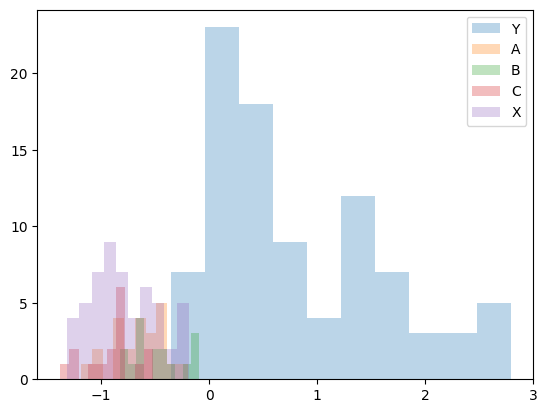

In [13]:
df_data_with_y = pd.concat([df[['Drug']], X[dependent_vars]] , axis=1)
df_data_with_y['y'] = X[dependent_vars]@(qualitization_vector)

print('mean of y in each group')
print(df_data_with_y.groupby('Drug')['y'].mean())

mapper_label = {'DrugY':'Y', 'drugA':'A', 'drugB':'B', 'drugC':'C', 'drugX':'X'}
df_data_with_y.groupby('Drug')[['Drug', 'y']].apply(lambda x : plt.hist(x['y'], alpha=0.3, label=mapper_label[x['Drug'].values[0]]))

plt.legend()
plt.show()

thus, I have the result of quantification-Ⅱ as:

$$
\begin{align}
a_{Age} &=  0.062 \\
a_{Na\_to\_K} &= 0.966 \\
a_{Sex\_F} &= 0 \\
a_{Sex\_M} &= 0.096 \\
a_{BP\_H} &= 0 \\
a_{BP\_L} &= -0.223 \\
a_{BP\_N} &= -0.056 \\
a_{Cho\_H} &= 0 \\
a_{Cho\_N} &= 0.016 \\
\end{align}
$$

We can understand the following facts form the above result:

- Na to Potassium Ration the most influence on DrugY.
- BP_Low is a likely facter in recomending drugX.
- Although drugA, drugB and drugC have close figure of 'y', that is in the order of drugB, drugA, drugC.
- It is reasonable to say that patients who are given DrugY are differ from others.

## scatter visualization of data

In [14]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_total).dot(S_between))

argsort_ev = np.argsort(eig_vals)

idx_eta_square_2 = argsort_ev[-2] # 2番目に大きい固有値の列を取得
eta_square_2 = eig_vals[idx_eta_square_2] # 2番目に大きい固有値
qualitization_vector_2 = eig_vecs[:, idx_eta_square_2] # 2番目に大きい固有ベクトル

print('idx_eta_square_2:', idx_eta_square_2)
print('eta_square_2:', '{:.3f}'.format(eta_square_2))
np.set_printoptions(precision=3)
print('qualitization_vector_2:', qualitization_vector_2)

idx_eta_square_2: 0
eta_square_2: -85.650
qualitization_vector_2: [-0.064  0.058 -0.056  0.645  0.751  0.097]


In [15]:
df_data_with_y['y2'] = X[dependent_vars]@(qualitization_vector_2)
 
df_data_with_y

,Drug,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL,y,y2
0,DrugY,-1.288358,1.283302,0,0,0,0,1.160449,0.157106
1,drugC,0.162291,-0.414106,1,1,0,0,-0.516906,0.555439
2,drugC,0.162291,-0.826484,1,1,0,0,-0.915442,0.531607
3,drugX,-0.986139,-1.147084,0,0,1,0,-1.225333,0.747797
4,DrugY,1.008504,0.271114,0,1,0,0,0.101753,0.596166
...,...,...,...,...,...,...,...,...,...
195,drugC,0.706285,-0.625348,0,1,0,0,-0.783331,0.563813
196,drugC,-1.711464,-0.564578,1,1,0,0,-0.778352,0.667370
197,drugX,0.464510,-0.856938,1,0,1,0,-0.759143,0.615575
198,drugX,-1.288358,-0.285783,1,0,1,1,-0.299440,0.858618


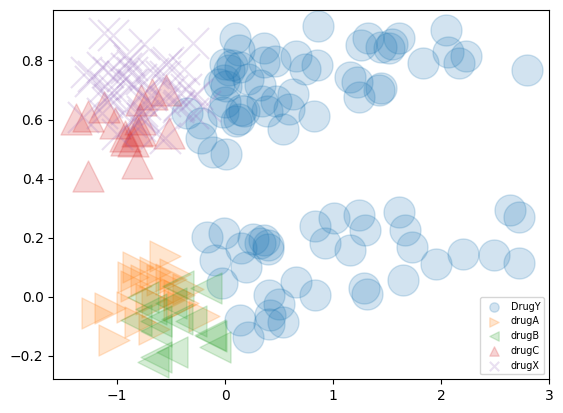

In [16]:
from matplotlib.legend_handler import HandlerTuple
markers = {
    'DrugY':'o',
    'drugA':'>',
    'drugB':'<',
    'drugC':'^',
    'drugX':'x'
}

# 1番目のyの値と2番目のyの値をプロット
for accurate_drug in ['DrugY', 'drugA', 'drugB', 'drugC', 'drugX']:
    data = df_data_with_y[df_data_with_y['Drug'] == accurate_drug]
    plt.scatter(data['y'], data['y2'], s=500, marker=markers[accurate_drug], alpha=0.2, label=accurate_drug)
    

# Set the legend handler to change the marker size only
plt.legend(fontsize='x-small',markerscale=0.3)
plt.show()

## scatter visualization of category

In [17]:
def centerize_qualitization(qual):
    '''
    ダミー変数かした列の固有ベクトルから元の列の固有ベクトル（固有ベクトルの平均)の差を算出

    各列の平均が1なので列のy1、y2が求められる
    '''
    y_age = qual[:1]
    y_NK = qual[1:2]
    y_sex = np.concatenate([[0], qual[2:3]])
    y_bp = np.concatenate([[0], qual[3:5]])
    y_cho = np.concatenate([[0],qual[5:]])
    
    y_sex = y_sex - y_sex.mean()
    y_bp = y_bp - y_bp.mean()
    y_cho = y_cho - y_cho.mean()
    
    return np.concatenate([y_age, y_NK, y_sex, y_bp, y_cho])

In [18]:
y1 = centerize_qualitization(qualitization_vector)
y2 = centerize_qualitization(qualitization_vector_2)

df_qualitization = pd.DataFrame(
    {
        'category': ['Age', 'Na_to_K', 'Sex_F', 'Sex_M', 'BP_HIGH', 'BP_LOW', 'BP_NORMAL', 'Cholesterol_HIGH', 'Cholesterol_NORMAL'],
        'y1': y1,
        'y2': y2,
    })

df_qualitization

,category,y1,y2
0,Age,0.061921,-0.064377
1,Na_to_K,0.966433,0.057792
2,Sex_F,-0.047979,0.027801
3,Sex_M,0.047979,-0.027801
4,BP_HIGH,0.092800,-0.465342
5,BP_LOW,-0.129909,0.180080
6,BP_NORMAL,0.037109,0.285263
7,Cholesterol_HIGH,-0.008129,-0.048595
8,Cholesterol_NORMAL,0.008129,0.048595


visualiztion of categories


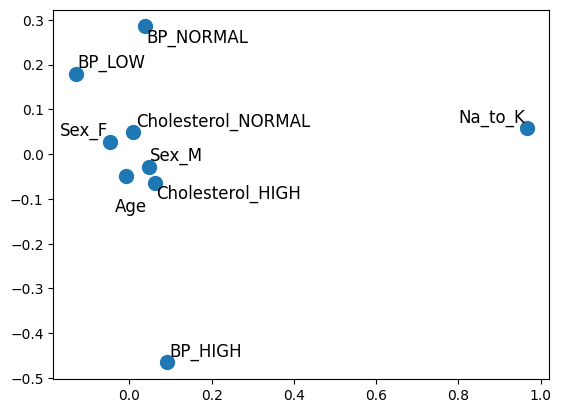

In [19]:
# y1とy2の軸にカテゴリーをプロット
plt.scatter(df_qualitization['y1'], df_qualitization['y2'], s=100)
texts = [plt.text(df_qualitization['y1'][i], df_qualitization['y2'][i], df_qualitization['category'][i], fontsize=12, ha='center', va='center') for i in range(len(df_qualitization))]
adjust_text(texts)

print("visualiztion of categories")

I have the result form above chart:

- DrugY pretty depens on Na_to_k.
- BP makes a big difference in drugA or drugB and drugC or drugX.